In [41]:
# computation
import numpy as np
import tensorflow as tf
import prettytensor as pt

# utility funcs
from numpy.random import normal,random_sample
from datetime import datetime
from scipy.stats import norm

# visualization
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
%matplotlib inline

In [2]:
latent_size = 1
batch_size = 200
data_size = 1

# for Adam optimizer:
eta = 2e-4
beta1 = 0.5

# Data distribution $p_{data}$

$$
p_{data} = \mathcal{N}\bigg(1, 1\bigg)
$$

In [5]:
def gen_data(n_samples):
    """generate data according to p_data"""
    return normal(loc=1, scale=1, size=(n_samples,1))

def gen_noise(batch_size, latent_dim):
    """generate n_samples of random noise"""
    return random_sample((batch_size, latent_dim))

In [6]:
def viz_data(data, i):
    """Plot a scatterplot of the given data"""
    assert data.shape[1] == 1
    f, ax = plt.subplots(figsize=(6,4))

    # plot p_data
    x = np.linspace(-3,5,1000)
    y = norm.pdf(x, loc=1, scale=1)    # for example
    p = plt.plot(x,y, label='p_data')

    # draw data
    sns.distplot(data, label='data', norm_hist=True)
    
    # draw decision boundary
    # TODO
    f.suptitle('1D Generative Adversarial Network', fontsize=15)
    frame_text = ax.text(0.02, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
    frame_text.set_text('Timestep = %.1d' % i)
    ax.legend()

In [7]:
data = gen_data(2000)

NameError: name 'normal' is not defined

In [8]:
viz_data(data)

NameError: name 'data' is not defined

In [7]:
def generator(input_data):
    with pt.defaults_scope(activation_fn=tf.nn.tanh, variable_collections=['generator']):
        return (pt.wrap(input_data).flatten()
               .fully_connected(data_size))

In [8]:
def discriminator(input_data):
    with pt.defaults_scope(activation_fn=tf.nn.tanh, variable_collections=['discriminator']):
        return (pt.wrap(input_data).flatten()
               .fully_connected(2)
               .fully_connected(1, activation_fn=tf.nn.sigmoid)
               )

In [30]:
tf.reset_default_graph()
data_tensor = tf.placeholder(np.float32, shape=(batch_size, data_size))
noise_tensor = tf.placeholder(np.float32, shape=(batch_size, latent_size))


output_g = generator(noise_tensor)
output_d_real = discriminator(data_tensor)
output_d_fake = discriminator(output_g)

# discriminator loss (for both cases)
# max log(D(x)) + log(1 - D(z))
loss_d_real = -tf.reduce_mean(tf.log(output_d_real + 1e-12))
loss_d_fake = -tf.reduce_mean(tf.log((1 - output_d_fake) + 1e-12))
loss_d = loss_d_real + loss_d_fake

# generator loss
# max D(G(z))
loss_g = -tf.reduce_mean(tf.log(loss_d_fake + 1e-12))

In [31]:
summary_d = [
    tf.scalar_summary('loss_d_real', loss_d_real),
    tf.scalar_summary('loss_d_fake', loss_d_fake)
    ]
summary_g = [
    tf.scalar_summary('loss_g', loss_g)
]
merged_d = tf.merge_summary(summary_d)
merged_g = tf.merge_summary(summary_g)

In [32]:
vars_d = tf.get_collection('discriminator')
vars_g = tf.get_collection('generator')

In [33]:
assert len(vars_g) == 2
assert len(vars_d) == 4 * 2

In [34]:
opt_d = tf.train.AdamOptimizer(eta, beta1=beta1)\
            .minimize(loss_d, var_list = vars_d)

opt_g = tf.train.AdamOptimizer(eta, beta1=beta1)\
            .minimize(loss_g, var_list = vars_g)

In [35]:
init_op = tf.initialize_all_variables()

In [36]:
#sess = tf.Session()
#sess.run(init_op)

In [37]:
now = str(datetime.now()).replace(' ', '_').replace(':', '_')
run = 0

0.949486
overpowering
0.951506
overpowering
0.950232
overpowering
0.950151
overpowering
0.949437
overpowering
0.950044
overpowering
0.950183
overpowering
0.948472
overpowering
0.950073
overpowering
0.949597
overpowering
0.949409
overpowering
0.949479
overpowering
0.949182
overpowering
0.948896
overpowering
0.948533
overpowering
0.94938
overpowering
0.94777
0.949376
0.950596
overpowering
0.950299
overpowering
0.950808
overpowering
0.950349
overpowering
0.950056
overpowering
0.949713
overpowering


KeyboardInterrupt: 

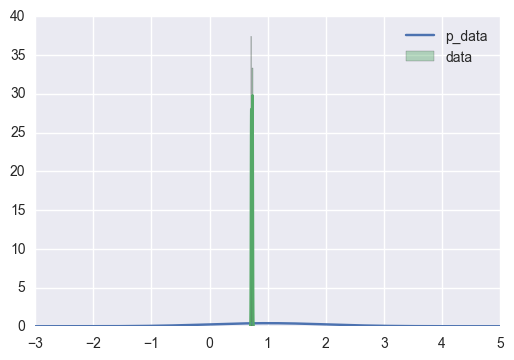

In [39]:
run += 1
sess = tf.Session()
sess.run(init_op)
sum_writer = tf.train.SummaryWriter('logs_{}/{}'.format(now, run), sess.graph)

num_epochs = 200000
n_k = 1
real_data = gen_data(batch_size)

for epoch in range(0, num_epochs):
    # update discriminator $k$ times
    for k in range(0, n_k):
        noise = gen_noise(batch_size, latent_size)
        # run discriminator on real data this time
        l_d, _ = sess.run([loss_d, opt_d] , {data_tensor: real_data, noise_tensor: noise})
        
        #l_d, summary = sess.run([loss_d, merged_d], {data_tensor: real_data, noise_tensor: noise})
        #if k == n_k-1:
            #sum_writer.add_summary(summary, epoch)
    noise = gen_noise(batch_size, latent_size)
    l_g, _ = sess.run([loss_g, opt_g], {noise_tensor: noise})
    print(l_g)
    if l_d < l_g/2:
        # prevent the discriminator from overpowering the generator
        n_k = 0
        print('overpowering')
    else:
        n_k = 1
        
    #l_g, summary = sess.run([loss_g, merged_g], {noise_tensor: noise})
    #sum_writer.add_summary(summary, epoch)
    
    if epoch % 100 == 0:
        #print('epoch {}/{}: {}%'.format(epoch, num_epochs, epoch/num_epochs))
                
        x = np.linspace(-3, 5, 100000)
        
        l_d, summary_d = sess.run([loss_d, merged_d], {data_tensor: real_data, noise_tensor: noise})
        sum_writer.add_summary(summary_d, epoch)
        l_g, summary_g, o_g = sess.run([loss_g, merged_g, output_g], {noise_tensor: noise})
        sum_writer.add_summary(summary_g, epoch)
        #print('generator: {}, discriminator: {}'.format(l_g, l_d))
        #o_g, = sess.run([output_g], {noise_tensor: noise})
        #print(o_g.shape)
        plt.cla()
        viz_data(o_g)
        display.display(plt.gcf())
        display.clear_output(wait=True)